# PA 4: Comparison of Boosted Perceptrons and SVM

PA4 by Wilson Franz Bolo

**Notes**:
- AdaBoost parts should take a total of around 20 minutes (based on previous runs: ~8 mins each for the dataset)
- SVM parts should take around 40 minutes (based on previous runs: ~5 mins for banana, ~35 mins for splice)
- Change libsvm_path (path for the libsvm/python folder) in SVM Initialization cell to modify the code being used for SVM

# Initialization

In [5]:
%%time

# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import random

# Seeds
seed = 10
np.random.seed(seed)
random.seed(seed)

##### PERCEPTRON CLASSIFIER Generated Dataset

# Generating datasets for the perceptron classifier--- negative (neg) and positive (pos) classes
mean_neg, mean_pos = [0, 0], [10, 10]
cov = [[1, 0], [0, 1]]
samples_neg = np.random.multivariate_normal(mean_neg, cov, size=100)
samples_pos = np.random.multivariate_normal(mean_pos, cov, size=100)

# Create labeled data
data = [(x, -1) for x in samples_neg] + [(x, 1) for x in samples_pos]
random.shuffle(data)

# Split into train/test
gen_train_data = np.array([x[0] for x in data[:100]])
gen_train_label = np.array([x[1] for x in data[:100]])
gen_test_data = np.array([x[0] for x in data[100:]])
gen_test_label = np.array([x[1] for x in data[100:]])


##### ADABOOST and SVM Datasets

# Extracting the banana data set
banana_df = pd.read_csv('banana_data.csv', header=None)
banana_data = banana_df.values.tolist()
random.shuffle(banana_data)

# Split into train/test
banana_train_data = np.array([x[1:] for x in banana_data[:400]])
banana_train_label = np.array([x[0] for x in banana_data[:400]])
banana_test_data = np.array([x[1:] for x in banana_data[400:]])
banana_test_label = np.array([x[0] for x in banana_data[400:]])


# Extracting the splice data set
splice_df = pd.read_csv('splice_data.csv', header=None)
splice_data = splice_df.values.tolist()
random.shuffle(splice_data)

# Split into train/test
splice_train_data = np.array([x[1:] for x in splice_data[:1000]])
splice_train_label = np.array([x[0] for x in splice_data[:1000]])
splice_test_data = np.array([x[1:] for x in splice_data[1000:]])
splice_test_label = np.array([x[0] for x in splice_data[1000:]])


CPU times: total: 1.08 s
Wall time: 1.49 s


## EDA of the datasets

--- Banana Dataset ---
Number of samples: 5300
Number of features: 2
Label Distribution: {-1.0: 2924, 1.0: 2376}


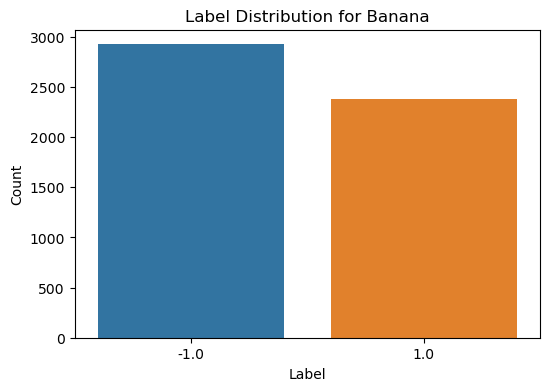


Basic Statistics on Features:
                  0             1
count  5.300000e+03  5.300000e+03
mean  -3.889075e-10 -3.304355e-10
std    1.000000e+00  1.000000e+00
min   -3.089839e+00 -2.385937e+00
25%   -7.533486e-01 -9.139026e-01
50%   -1.523143e-02 -3.721518e-02
75%    7.818310e-01  8.221039e-01
max    2.813360e+00  3.194302e+00

--- Splice Dataset ---
Number of samples: 2991
Number of features: 60
Label Distribution: {-1.0: 1647, 1.0: 1344}


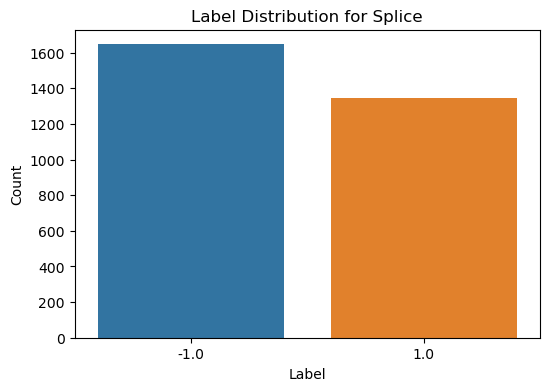


Basic Statistics on Features:
                0            1            2            3            4   \
count  2991.000000  2991.000000  2991.000000  2991.000000  2991.000000   
mean      2.490471     2.496824     2.526914     2.506854     2.507188   
std       1.086475     1.103918     1.081864     1.096606     1.118646   
min       1.000000     1.000000     1.000000     1.000000     1.000000   
25%       2.000000     2.000000     2.000000     2.000000     1.000000   
50%       2.000000     3.000000     3.000000     3.000000     3.000000   
75%       3.000000     3.000000     3.000000     3.000000     3.000000   
max       4.000000     4.000000     4.000000     4.000000     4.000000   

                5            6            7            8            9   ...  \
count  2991.000000  2991.000000  2991.000000  2991.000000  2991.000000  ...   
mean      2.542962     2.504179     2.520227     2.541625     2.532598  ...   
std       1.080726     1.107242     1.111889     1.102531     1.1

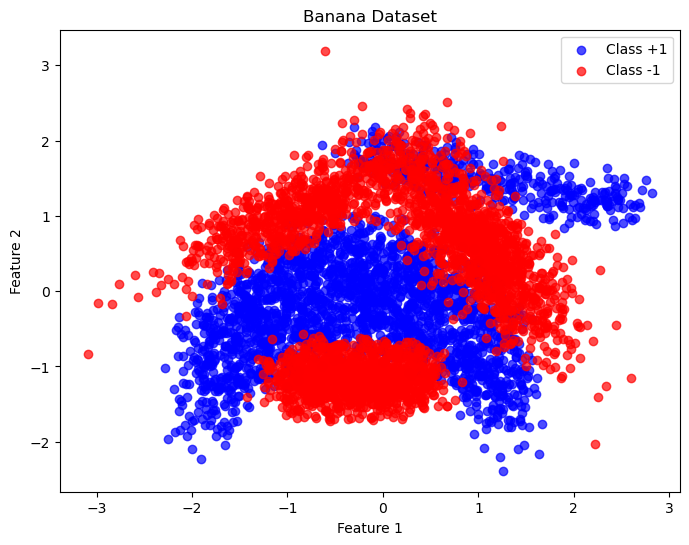

CPU times: total: 438 ms
Wall time: 484 ms


In [7]:
%%time

# Function to perform EDA on datasets
def eda(dataset_name, data, labels):
    print(f"--- {dataset_name} Dataset ---")
    
    # Number of data points and features
    num_samples, num_features = data.shape
    print(f"Number of samples: {num_samples}")
    print(f"Number of features: {num_features}")
    
    # Label distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    label_dist = dict(zip(unique_labels, counts))
    print(f"Label Distribution: {label_dist}")
    
    # Plot label distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=labels)
    plt.title(f"Label Distribution for {dataset_name}")
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.show()
    
    # Basic statistics on features
    print("\nBasic Statistics on Features:")
    feature_stats = pd.DataFrame(data).describe()
    print(f"{feature_stats}\n")

## Perform EDA on datasets
eda("Banana", np.array(banana_data)[:, 1:], np.array(banana_data)[:, 0])
eda("Splice", np.array(splice_data)[:, 1:], np.array(splice_data)[:, 0])

## Plotting the banana dataset
data = np.array(banana_data)[:, 1:]
labels = np.array(banana_data)[:, 0]

# Separate the classes
class_pos = data[labels == 1]
class_neg = data[labels == -1]

plt.figure(figsize=(8, 6))
plt.scatter(class_pos[:, 0], class_pos[:, 1], c='blue', label='Class +1', alpha=0.7)
plt.scatter(class_neg[:, 0], class_neg[:, 1], c='red', label='Class -1', alpha=0.7)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Banana Dataset")
plt.legend()
plt.show()

## Perceptron Classifier

In [9]:

# FUNCTION: classify (to train the perceptron with the Pocket Algorithm)
def classify(train_data, train_label, v=None, train_weights=None, maxitercnt=10000, seed=10):

    # Initializing the seed, initial values, and initial weight vector
    rng = np.random.default_rng(seed)
    n_w, n_v, itercnt = 0, 0, 0
    w = None

    if v is None or len(v) == 0:
        v = rng.random((1, train_data.shape[1] + 1)) # weight vector (bias is the last element)
    if train_weights is None or len(train_weights) == 0:    
        train_weights = np.ones(train_data.shape[0])/train_data.shape[0]
    
    while itercnt < maxitercnt:

        # Randomly selecting an input pattern and associated label
        num = rng.choice(train_data.shape[0], p=train_weights)
        x_input = np.append(train_data[num], 1) # Add bias
        y_input = train_label[num]

        # Calculating the neuron's output
        dot_prod = np.dot(v, x_input)
        y_predicted = 1 if dot_prod >= 0 else -1

        # Updating the counters and weight vectors
        if y_input * y_predicted > 0:
            n_v += 1
        else:
            if n_v > n_w: # Storing weight vector into the pocket
                w = v.copy()
                n_w = n_v
        
            v = v + y_input * x_input
            n_v = 0
            
        itercnt += 1
    
    # Returning the weight vector with the most consecutive iterations of correct classification 
    return w if w is not None else v

# FUNCTION: predict (to test the perceptron)
def predict(test_data, test_label, w):

    # Incorporating 1 into the test data for the bias
    bias = np.ones((test_data.shape[0], 1))
    test_with_bias = np.hstack((test_data, bias))

    # Calculating the predicted label
    dot_prod = np.dot(test_with_bias, w.T)
    y_predicted = np.where(dot_prod >= 0, 1, -1).flatten()

    return y_predicted


# AdaBoost

In [11]:

# FUNCTION: adabtrain (to implement the Adaboost algorithm with the Pocket Algorithm)
def adabtrain(train_data, train_label, K, seed=10):

    # Initializing the weight probability vector, lerner weight, and dictionry for storing a_t and h_t values
    rng = np.random.default_rng(seed)
    weights = np.ones(train_data.shape[0])/train_data.shape[0]
    ensemble_classifier = {}
    
    # Iterating until K iterations
    for t in range(K):
        
        # Mak sure that the training error is less than 0.5
        e_t = 1
        while e_t > 0.5:
            
            # Selecting new training set, S_t
            sampled_indices = rng.choice(train_data.shape[0], size=train_data.shape[0], replace=True, p=weights)
            new_train_data, new_train_label = train_data[sampled_indices], train_label[sampled_indices]
        
            # Training weak learner to obtain hypothesis, h_t, and training error, e_t
            w_t = classify(new_train_data, new_train_label)
            h_t = predict(train_data, train_label, w_t)
            e_t = np.sum((h_t != train_label) * weights)  
    
        # Calculating the coefficient, a_t, and saving a_t and learner weights to the dictionary
        a_t = 0.5*np.log((1 - e_t) / e_t)
        ensemble_classifier[t+1] = {'a_t': a_t, 'w': w_t}
    
        # Updating the weights
        weights *= np.exp(-a_t * train_label * h_t)
        weights /= np.sum(weights)
    
    # Returning the ensemble classifier (the coefficients and the weights of each weak learner)
    return ensemble_classifier


# FUNCTION: adabpredict (to classify unseen data using the ensemble classifier)
def adabpredict(test_data, test_label, ensemble):

    # Initializing the H(x) values
    H_x = np.zeros(test_data.shape[0])
    
    # Calculating the "prediction" for each classifier, multiplying the coefficient, and adding up to the H(x) values
    for v in ensemble.values():
        a_t = v['a_t']
        w_t = v['w']
        h_t = predict(test_data, test_label, w_t)
        H_x += a_t * h_t
    
    # Checking the sign of the H(x) values to output the final prediction
    final_pred = np.where(H_x >= 0, 1, -1)
    return final_pred


# FUNCTION: adabkcurve (to plot the accuracy at different K learners)
def adabkcurve(train_data, train_label, test_data, test_label, K, seed=10):

    # Initializing the weight probability vector, lerner weight, and dictionry for storing a_t and h_t values
    rng = np.random.default_rng(10)
    weights = np.ones(train_data.shape[0])/train_data.shape[0]
    ensemble_classifier = {}
    
    # Initializing the lists needed to output the plot
    train_misclass, test_misclass, K_values = [], [], []
    best_acc = 0
    best_param = {}

    # Iterating until K iterations
    for t in range(K):
    
        # Mak sure that the training error is less than 0.5
        e_t = 1
        attempt = 0
        while e_t > 0.5:
            
            # Selecting new training set, S_t
            sampled_indices = rng.choice(train_data.shape[0], size=train_data.shape[0], replace=True, p=weights)
            new_train_data, new_train_label = train_data[sampled_indices], train_label[sampled_indices]
        
            # Training weak learner to obtain hypothesis, h_t, and training error, e_t
            w_t = classify(new_train_data, new_train_label)
            h_t = predict(train_data, train_label, w_t)
            e_t = np.sum((h_t != train_label) * weights) 
            attempt += 1
    
        # Calculating the coefficient, a_t, and saving a_t and learner weights to the dictionary
        a_t = 0.5*np.log((1 - e_t) / e_t)
        ensemble_classifier[t+1] = {'a_t': a_t, 'w': w_t}
    
        # Updating the weights
        weights *= np.exp(-a_t * train_label * h_t)
        weights /= np.sum(weights)

        # Storing the values at every 10th K learners
        if (t+1) % 10 == 0:
            print(f"t = {t+1}: Training error = {e_t:.4f} (required {attempt} attempt(s))")

            # Predicting the training and testing label using the ensemble
            train_pred = adabpredict(train_data, train_label, ensemble_classifier)
            final_pred = adabpredict(test_data, test_label, ensemble_classifier)

            # Calculating the training and testing accuracy
            train_misclass.append(1 - np.mean(train_pred == train_label))
            test_misclass.append(1 - np.mean(final_pred == test_label))
            K_values.append(t+1)

            acc = np.mean(final_pred == test_label)
            # Update the best model if the current one is better
            if acc > best_acc:
                best_acc = acc
                best_param = {'K': t+1, 'train_pred': train_pred, 'test_pred': final_pred, 'a_t': a_t, 'w': w_t}

    # Creating the arrays to be plotted
    train_misclass, test_misclass = np.array(train_misclass), np.array(test_misclass)
    min_error, min_error_K = np.min(test_misclass), K_values[np.argmin(test_misclass)]
    min_error_hor = np.ones(len(K_values)) * min_error
    min_error_ver1 = np.linspace(min(train_misclass.min(), test_misclass.min()),
                                 max(train_misclass.max(), test_misclass.max()), 100)
    min_error_ver2 = np.ones(len(min_error_ver1)) * min_error_K
    
    # Plotting K against accuracies
    plt.plot(K_values, train_misclass, label = "Train", color = "blue")
    plt.plot(K_values, test_misclass, label = "Test", color = "red")
    
    # Plotting the horizontal and vertical lines to show the K with the minimum training error
    plt.plot(K_values, min_error_hor, label = f"Min Error: {min_error:.4f}", color = "tomato", linestyle="dashed")
    plt.plot(min_error_ver2, min_error_ver1, label = f"K (Min Error): {min_error_K}", color = "tomato", linestyle="dashed")
    
    plt.xlabel('K')
    plt.ylabel('Misclassification Rate')
    plt.title('K vs. Misclassification Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return best_acc, best_param


# FUNCTION: adabeval (to evaluate the performance of the classifier)
def adabeval(y_true, y_pred):

    # Calculate the true positive, true negatives, false positives, and false negatives
    TP = np.sum((y_pred == 1) & (y_true == 1))
    TN = np.sum((y_pred == -1) & (y_true == -1))
    FP = np.sum((y_pred == 1) & (y_true == -1))
    FN = np.sum((y_pred == -1) & (y_true == 1))
    
    # Calculating performance metrics
    accuracy = (TP + TN) / len(y_true)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    sensitivity = TP /  (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN /  (TN + FP) if (TN + FP) > 0 else 0
    PPV = TP /  (TP + FP) if (TP + FP) > 0 else 0
    NPV = TN /  (TN + FN) if (TN + FN) > 0 else 0
    bal_acc = 0.5 * (sensitivity + specificity)
    
    mcc_numerator = (TP * TN) - (FP * FN)
    mcc_denominator = np.sqrt(TP + FP) * np.sqrt(TP + FN) * np.sqrt(TN + FP) * np.sqrt(TN + FN)
    mcc = mcc_numerator / mcc_denominator if mcc_denominator != 0 else 0

    results = {
        "TP": TP,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "Accuracy": accuracy*100,
        "Precision": precision*100,
        "Recall": recall*100,
        "F1 Score": f1*100,
        "Sensitivity": sensitivity*100,
        "Specificity": specificity*100,
        "PPV": PPV*100,
        "NPV": NPV*100,
        "Balanced Accuracy": bal_acc*100,
        "MCC": mcc*100,
    }
    
    return results

## Banana Dataset - AdaBoost

t = 10: Training error = 0.3922 (required 1 attempt(s))
t = 20: Training error = 0.4684 (required 3 attempt(s))
t = 30: Training error = 0.4281 (required 2 attempt(s))
t = 40: Training error = 0.4269 (required 1 attempt(s))
t = 50: Training error = 0.4066 (required 1 attempt(s))
t = 60: Training error = 0.4476 (required 1 attempt(s))
t = 70: Training error = 0.4321 (required 1 attempt(s))
t = 80: Training error = 0.4501 (required 1 attempt(s))
t = 90: Training error = 0.4612 (required 2 attempt(s))
t = 100: Training error = 0.4698 (required 1 attempt(s))
t = 110: Training error = 0.4435 (required 2 attempt(s))
t = 120: Training error = 0.4429 (required 1 attempt(s))
t = 130: Training error = 0.4970 (required 1 attempt(s))
t = 140: Training error = 0.4845 (required 1 attempt(s))
t = 150: Training error = 0.4970 (required 1 attempt(s))
t = 160: Training error = 0.4363 (required 1 attempt(s))
t = 170: Training error = 0.4698 (required 1 attempt(s))
t = 180: Training error = 0.4599 (requir

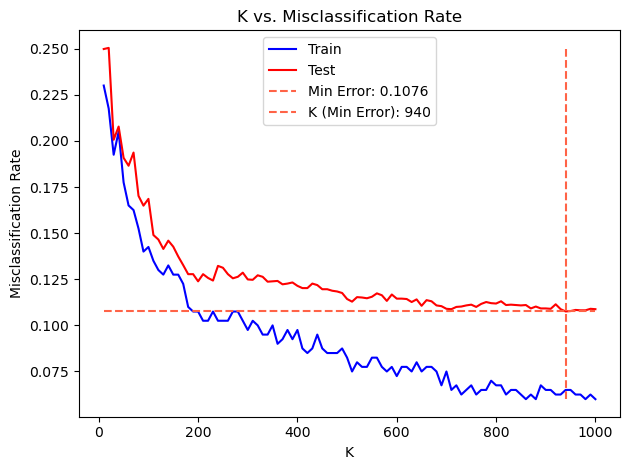


Performance Evaluation at Best Configuration:
TP: 1923.00
TN: 2450.00
FP: 245.00
FN: 282.00
Accuracy: 89.24
Precision: 88.70
Recall: 87.21
F1 Score: 87.95
Sensitivity: 87.21
Specificity: 90.91
PPV: 88.70
NPV: 89.68
Balanced Accuracy: 89.06
MCC: 78.25
CPU times: total: 7min 2s
Wall time: 7min 6s


In [13]:
%%time

# Assigning the datasets
train_data = banana_train_data
train_label = banana_train_label
test_data = banana_test_data
test_label = banana_test_label

# Creating the K learners curve
banana_acc, banana_out = adabkcurve(train_data, train_label, test_data, test_label, K=1000)

# Evaluating further the ensemble at the lowest testing misclassification error
banana_pred = np.array(banana_out['test_pred'])
banana_eval = adabeval(test_label, banana_pred)
print("\nPerformance Evaluation at Best Configuration:")
for k, v in banana_eval.items():
    print(f"{k}: {v:.2f}")

## Splice Dataset - AdaBoost

t = 10: Training error = 0.4585 (required 1 attempt(s))
t = 20: Training error = 0.4713 (required 1 attempt(s))
t = 30: Training error = 0.4999 (required 1 attempt(s))
t = 40: Training error = 0.4962 (required 1 attempt(s))
t = 50: Training error = 0.4843 (required 1 attempt(s))
t = 60: Training error = 0.4823 (required 3 attempt(s))
t = 70: Training error = 0.4771 (required 2 attempt(s))
t = 80: Training error = 0.4882 (required 1 attempt(s))
t = 90: Training error = 0.4685 (required 1 attempt(s))
t = 100: Training error = 0.4731 (required 1 attempt(s))
t = 110: Training error = 0.4713 (required 1 attempt(s))
t = 120: Training error = 0.4941 (required 1 attempt(s))
t = 130: Training error = 0.4931 (required 1 attempt(s))
t = 140: Training error = 0.4777 (required 3 attempt(s))
t = 150: Training error = 0.4881 (required 1 attempt(s))
t = 160: Training error = 0.4670 (required 1 attempt(s))
t = 170: Training error = 0.4821 (required 1 attempt(s))
t = 180: Training error = 0.4785 (requir

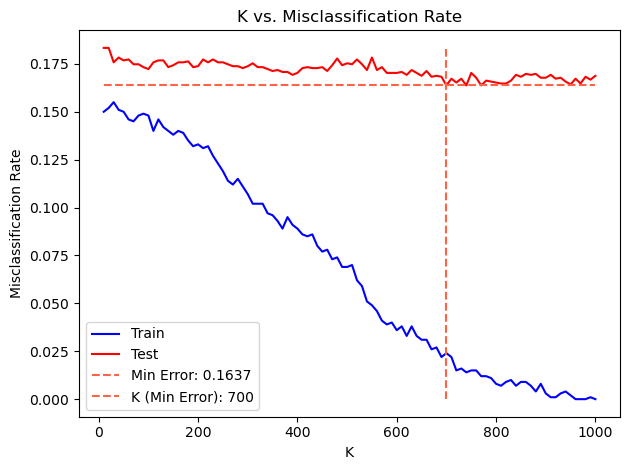


Performance Evaluation at Best Configuration:
TP: 751.00
TN: 914.00
FP: 169.00
FN: 157.00
Accuracy: 83.63
Precision: 81.63
Recall: 82.71
F1 Score: 82.17
Sensitivity: 82.71
Specificity: 84.40
PPV: 81.63
NPV: 85.34
Balanced Accuracy: 83.55
MCC: 67.04
CPU times: total: 28min 23s
Wall time: 7min 29s


In [15]:
%%time

# Assigning the datasets
train_data = splice_train_data
train_label = splice_train_label
test_data = splice_test_data
test_label = splice_test_label

# Creating the K learners curve
splice_acc, splice_out = adabkcurve(train_data, train_label, test_data, test_label, K=1000)

# Evaluating further the ensemble at the lowest testing misclassification error
splice_pred = np.array(splice_out['test_pred'])
splice_eval = adabeval(test_label, splice_pred)
print("\nPerformance Evaluation at Best Configuration:")
for k, v in splice_eval.items():
    print(f"{k}: {v:.2f}")

# SVM Initialization

In [17]:
%%time

# Utilization the provided LibSVM codes
import sys
from pathlib import Path
libsvm_path = Path(r"C:\Users\W-F-BOLO\OneDrive - University of the Philippines\Documents\0_MEngAI\[1-2] AI 201\PA4\libsvm-3.17\python").resolve()
sys.path.insert(0, str(libsvm_path))
from svmutil import *
import svmutil

# To make sure that the provided codes are used
print("Using svmutil from:", svmutil.__file__)
 
import random
random.seed(10)

# Load the datasets
banana_label, banana_data = svmutil.svm_read_problem('banana_data.libsvm')
combined = list(zip(banana_label, banana_data))
random.shuffle(combined)
banana_label, banana_data = zip(*combined)

splice_label, splice_data = svmutil.svm_read_problem('splice_data.libsvm')
combined = list(zip(splice_label, splice_data))
random.shuffle(combined)
splice_label, splice_data = zip(*combined)


# Define the kernels to test
kernels = {
    'linear': {'type': 0, 'param': '-t 0'},  # Linear kernel
    'polynomial': {'type': 1, 'param': '-t 1'},  # Polynomial kernel
    'rbf': {'type': 2, 'param': '-t 2'},  # RBF kernel
}

# Define the C and gamma values to test
C_values = [2**i for i in range(-5, 16, 2)]       # From 2^-5 to 2^15
gamma_values = [2**i for i in range(-15, 4, 2)]   # From 2^-15 to 2^3


# FUNCTION: svmtuning (to find the best parameters of the model by finding the best accuracy)
def svmtuning(y_train, x_train, y_test, x_test, kernels, C_values, gamma_values):

    # Initialize variables to store best results
    best_acc = 0
    best_params = {}

    acc_values = {
        'linear': np.zeros((len(C_values), len(gamma_values))),  # Linear kernel
        'polynomial': np.zeros((len(C_values), len(gamma_values))),  # Polynomial kernel
        'rbf': np.zeros((len(C_values), len(gamma_values))),  # RBF kernel
    }
    
    # Grid search: Try all combinations of kernels, C, and gamma
    for kernel_name, kernel_info in kernels.items():
        i = 0
        for C in C_values:
            j = 0
            for gamma in gamma_values:
                # Define the parameters for this combination
                params = f"{kernel_info['param']} -c {C} -g {gamma}"
                print(f"\nTraining with {kernel_name} kernel, C={C}, gamma={gamma}...")
    
                # Train the model
                model = svmutil.svm_train(y_train, x_train, params)
    
                # Evaluate the model on the test set
                y_pred, acc, _ = svmutil.svm_predict(y_test, x_test, model)
    
                # Update the best model if the current one is better
                if acc[0] > best_acc:
                    best_acc = acc[0]
                    best_params = {'kernel': kernel_name, 'C': C, 'gamma': gamma, 'model': model, 'y_pred': y_pred}

                acc_values[kernel_name][i][j] += acc[0]
                j += 1

            i += 1
                
    # Print the best results
    print("\nFINAL RESULTS:")
    print(f"\nBest Accuracy (Lowest Misclassification Rate): {100-best_acc:.2f}%")
    print(f"Best Parameters: Kernel={best_params['kernel']}, C={best_params['C']}, Gamma={best_params['gamma']}")
    
    return best_acc, best_params, acc_values

# FUNCTION: svmplots (to show the accuracy at various SVM settings)
def svmplots(acc_values, C_values, gamma_values):
    
    for k, acc in acc_values.items():
    
        fig, ax = plt.subplots(figsize=(8, 6))
        cax = ax.imshow(acc, cmap='YlGnBu')
        
        # Show all ticks and label
        ax.set_xticks(np.arange(len(gamma_values)))
        ax.set_yticks(np.arange(len(C_values)))
        ax.set_xticklabels(gamma_values)
        ax.set_yticklabels(C_values)
        
        # Label axes
        plt.xlabel("Gamma")
        plt.ylabel("C")
        plt.title(f"SVM Accuracy Heatmap Using {k} kernel")
        
        # Rotate x labels
        plt.xticks(rotation=45)
        
        # Add text annotation for max accuracy
        for i in range(len(C_values)):
            for j in range(len(gamma_values)):
                if acc[i, j] == np.max(acc):
                    ax.text(j, i, f"{acc[i, j]:.1f}%", ha="center", va="center", color="white")
        
        # Add color bar
        fig.colorbar(cax, label='Accuracy (%)')
        plt.tight_layout()
        plt.show()
    

Using svmutil from: C:\Users\W-F-BOLO\OneDrive - University of the Philippines\Documents\0_MEngAI\[1-2] AI 201\PA4\libsvm-3.17\python\svmutil.py
CPU times: total: 109 ms
Wall time: 157 ms


## Banana dataset - SVM


Training with linear kernel, C=0.03125, gamma=3.0517578125e-05...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=0.0001220703125...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=0.00048828125...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=0.001953125...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=0.0078125...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=0.03125...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=0.125...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=0.5...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linear kernel, C=0.03125, gamma=2...
Accuracy = 55.1429% (2702/4900) (classification)

Training with linea

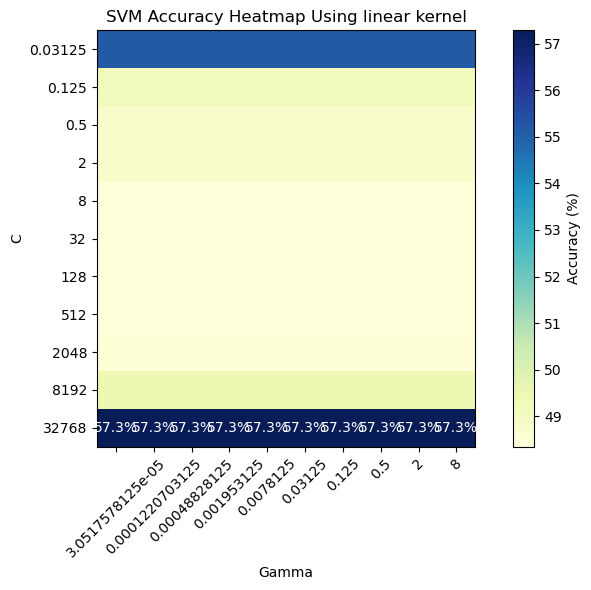

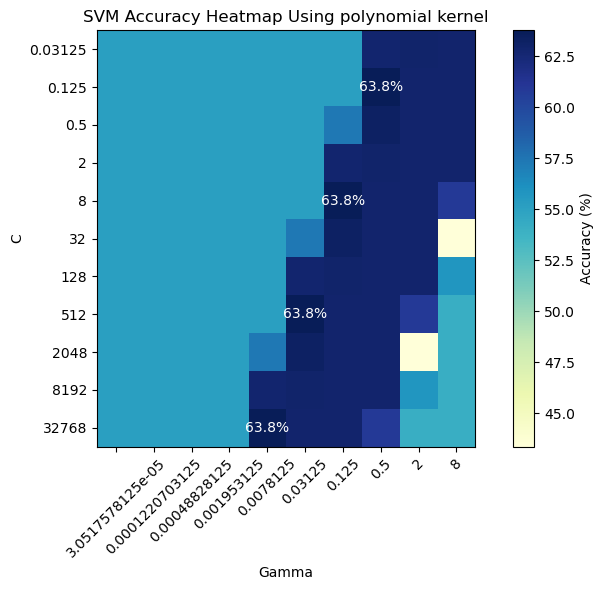

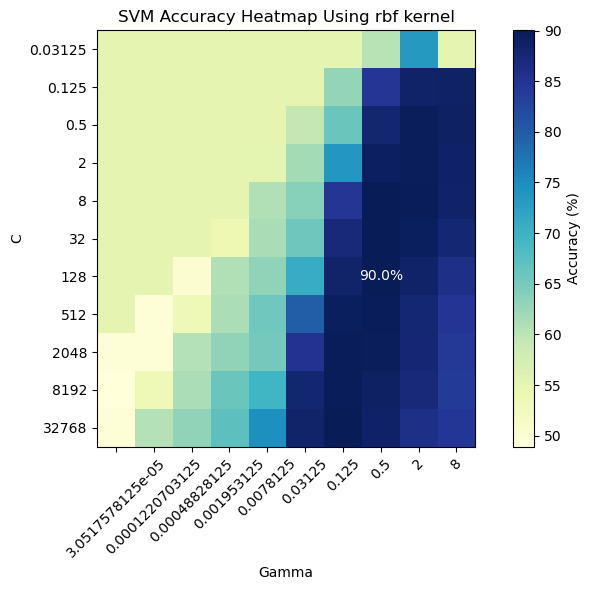


Performance Evaluation at Best Configuration:
TP: 1884.00
TN: 2527.00
FP: 175.00
FN: 314.00
Accuracy: 90.02
Precision: 91.50
Recall: 85.71
F1 Score: 88.51
Sensitivity: 85.71
Specificity: 93.52
PPV: 91.50
NPV: 88.95
Balanced Accuracy: 89.62
MCC: 79.84
CPU times: total: 4min 4s
Wall time: 4min 45s


In [19]:
%%time

y_all, x_all = banana_label, banana_data

# Split into training and test sets (400 training, 4900 test)
y_train, x_train = y_all[:400], x_all[:400]
y_test, x_test = y_all[400:], x_all[400:]

# Tuning the model
banana_accs, banana_outs, bacc_values = svmtuning(y_train, x_train, y_test, x_test, kernels, C_values, gamma_values)
svmplots(bacc_values, C_values, gamma_values)

# Evaluating the best model
banana_pred, y_test = np.array(banana_outs['y_pred']), np.array(y_test)
banana_eval = adabeval(y_test, banana_pred)
print("\nPerformance Evaluation at Best Configuration:")
for k, v in banana_eval.items():
    print(f"{k}: {v:.2f}")

## Splice dataset - SVM


Training with linear kernel, C=0.03125, gamma=3.0517578125e-05...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=0.0001220703125...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=0.00048828125...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=0.001953125...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=0.0078125...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=0.03125...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=0.125...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=0.5...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linear kernel, C=0.03125, gamma=2...
Accuracy = 83.4756% (1662/1991) (classification)

Training with linea

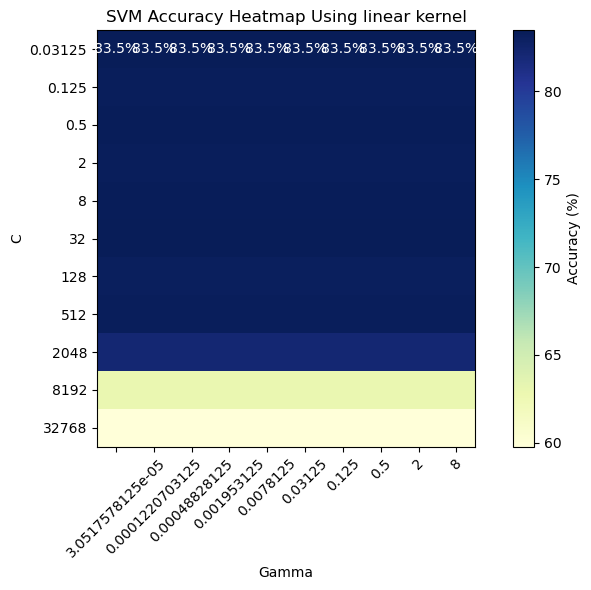

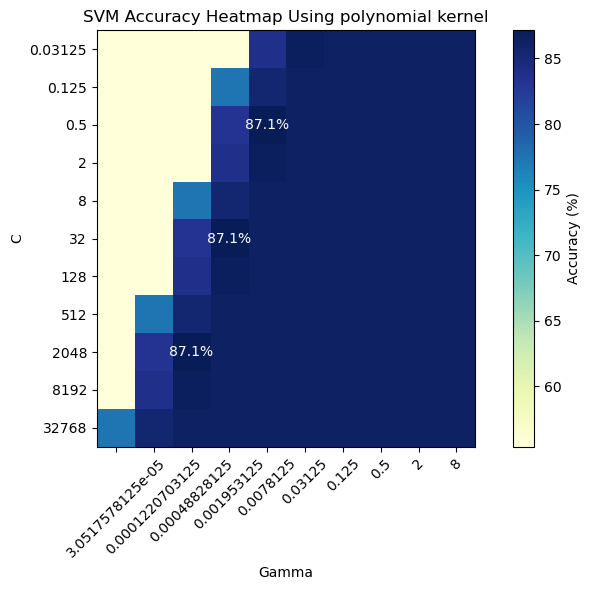

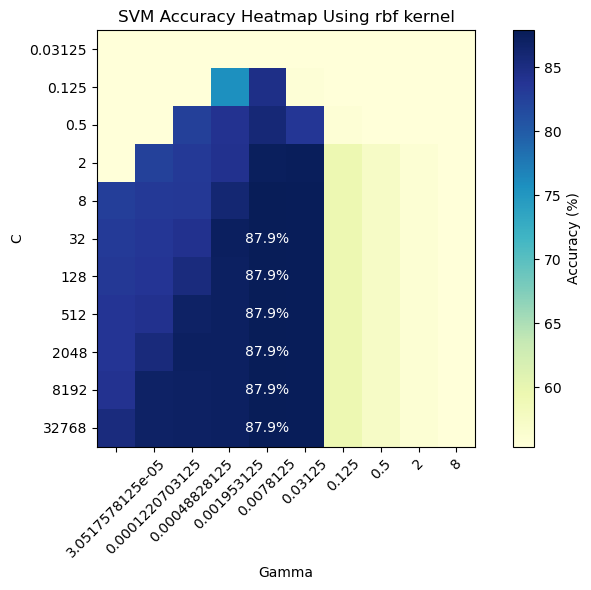


Performance Evaluation at Best Configuration:
TP: 801.00
TN: 949.00
FP: 154.00
FN: 87.00
Accuracy: 87.90
Precision: 83.87
Recall: 90.20
F1 Score: 86.92
Sensitivity: 90.20
Specificity: 86.04
PPV: 83.87
NPV: 91.60
Balanced Accuracy: 88.12
MCC: 75.86
CPU times: total: 30min 54s
Wall time: 32min 33s


In [21]:
%%time

y_all, x_all = splice_label, splice_data

# Split into training and test sets (1000 training, 1991 test)
y_train, x_train = y_all[:1000], x_all[:1000]
y_test, x_test = y_all[1000:], x_all[1000:]

# Tuning the model
splice_accs, splice_outs, sacc_values = svmtuning(y_train, x_train, y_test, x_test, kernels, C_values, gamma_values)
svmplots(sacc_values, C_values, gamma_values)

# Evaluating the best model
splice_pred, y_test = np.array(splice_outs['y_pred']), np.array(y_test)
splice_eval = adabeval(y_test, splice_pred)
print("\nPerformance Evaluation at Best Configuration:")
for k, v in splice_eval.items():
    print(f"{k}: {v:.2f}")